In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pathlib import Path
import networkx as nx
import pickle
import re
from IPython.display import display
from tqdm import tqdm
from skimage import io
import scipy as sp
import os
from scipy.ndimage import distance_transform_edt
import torch
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader
from IPython.display import clear_output
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import torch_geometric.transforms as T
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import rand_score
from sklearn.metrics import classification_report
#import pytorchgeometric as ptg

In [52]:
import numpy as np
from pathlib import Path
import re
import networkx as nx
import pickle
from skimage import io
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader
from tqdm import tqdm 
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphSAGE
from scipy.ndimage import distance_transform_edt
from os.path import exists
import torch_geometric.transforms as T

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    #z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    z = h.detach().numpy()
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.legend()
    plt.show()

In [16]:
folder = Path('/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_preds_graphs_fwhm_single_excel')
files = list(folder.glob('*_warped_radii_amended_AVC_v2.pickle'))
files = sorted([x.as_posix() for x in files])
print(files[0])
print(len(files))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#io.imread(files).shape

/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_preds_graphs_fwhm_single_excel/vbm03 Feb 26 2020-XYZres008_0001_warped_radii_amended_AVC_v2.pickle
82


In [34]:
param_files = list(Path('hyperparameter_pickle_files').glob('GraphSAGE*.pickle'))
param_files = sorted([x.as_posix() for x in param_files if 'SAGE8' in x.as_posix()])
param_file = param_files[55]
print(param_file)
with open(param_file, 'rb') as handle:
    params = pickle.load(handle)
params['num_layers'] = 30
params['aggr'] = ['mean','std']
params

hyperparameter_pickle_files/GraphSAGE849.pickle


{'dropout': 0.01,
 'learning_rate': 5e-06,
 'aggr': ['mean', 'std'],
 'hidden_channels': 16,
 'num_layers': 30,
 'batch_size': 8}

In [35]:
#param_files

In [36]:
#re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled',re.sub('_radii_amended_AVC.pickle','_mean.npy',file))

In [37]:
for file in files:
    with open(file, 'rb') as f:
        graph = pickle.load(f)
    res = []
    for edge in graph.edges:
        path = graph[edge[0]][edge[1]]['pts']
        res.append(np.max(path,axis=0))
    break
    #print(np.max(np.array(res),axis=0))

In [39]:
subjects = list(Path('/home/rozakmat/projects/rrg-bojana/rozakmat/James_VBM/datasets').glob('*'))
subjects = sorted([x.as_posix() for x in subjects])
np.random.seed(12)
np.random.shuffle(subjects)
train_subj = subjects[:4]
test_subj = subjects[4:6]
val_subj = subjects[6:]
train_imgs = list(np.concatenate([list(Path(x).glob('*.oir')) for x in train_subj]).flat)
train_imgs = np.unique(sorted([re.sub('_0001','',re.sub('.oir','',x.name)) for x in train_imgs]))
train_pickles = [x for x in files if any(y in x for y in train_imgs)]

test_imgs = list(np.concatenate([list(Path(x).glob('*.oir')) for x in test_subj]).flat)
test_imgs = np.unique(sorted([re.sub('_0001','',re.sub('.oir','',x.name)) for x in test_imgs]))
test_pickles = [x for x in files if any(y in x for y in test_imgs)]

val_imgs = list(np.concatenate([list(Path(x).glob('*.oir')) for x in val_subj]).flat)
val_imgs = np.unique(sorted([re.sub('_0001','',re.sub('.oir','',x.name)) for x in val_imgs]))
val_pickles = [x for x in files if any(y in x for y in val_imgs)]

#display(train_pickles)
#display(test_pickles)
display(val_pickles[0])
print(len(files))
data_list = []

for file in tqdm(train_pickles[:]):
    #file = 'James_labelling_AVC/james_preds/XYZres019_warped_single_radii_matched_AVC.pickle'
    with open(file, 'rb') as f:
        G = graph = pickle.load(f)
    tif_img = io.imread(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single',re.sub('_warped_radii_amended_AVC_v2.pickle','_warped.tif',file))).astype('float32')
    #img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([512,507,507])))
    #break
    if os.path.exists(re.sub('_warped_radii_amended_AVC.pickle','_warped_up.tif',file)):
        img_resized = io.imread(re.sub('_warped_radii_amended_AVC_v2.pickle','_warped_up.tif',file)).astype('float32')
    else:
        img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([254,512,512])))
        io.imsave(re.sub('_warped_radii_amended_AVC_v2.pickle','_warped_up.tif',file),img_resized)
    if os.path.exists(re.sub('_radii_amended_AVC_v2.pickle','_nrn_dst.tif',file)):
        nrn_dst = io.imread(re.sub('_radii_amended_AVC_v2.pickle','_nrn_dst.tif',file)).astype('float32')
    else:
        nrn_seg = 1 - (np.argmax(np.load(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled',re.sub('_radii_amended_AVC_v2.pickle','_mean.npy',file))),axis=0)==2)*1 #get neuron segmentation for more features
        nrn_dst = distance_transform_edt(nrn_seg) #get image of distance to nearest neuron
        io.imsave(re.sub('_radii_amended_AVC_v2.pickle','_nrn_dst.tif',file),nrn_dst)
    
    for edge in G.edges:
        for keys in G[edge[0]][edge[1]]:
            if type(G[edge[0]][edge[1]][keys]) == str:
                G[edge[0]][edge[1]][keys] = 0
        path = graph[edge[0]][edge[1]]['pts']
        path_smooth = np.float32(np.copy(path))  
        for k in range(len(path[0])):
            path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
        path_grad = np.gradient(path_smooth,edge_order=2)[0]
        path_grad = normalize(path_grad,axis=1)
        #if G[edge[0]][edge[1]]['start_depth'] == 0 or G[edge[0]][edge[1]]['start_depth'] == 
        G[edge[0]][edge[1]]['x'] = np.array([G[edge[0]][edge[1]]['weight'],
                                             G[edge[0]][edge[1]]['euclidean-dst'], #euclidean distance
                                             G[edge[0]][edge[1]]['euclidean-dst'] / G[edge[0]][edge[1]]['weight'], #Tortuosity
                                             G[edge[0]][edge[1]]['radii'],
                                             G[edge[0]][edge[1]]['radii_std'],
                                             #G[edge[0]][edge[1]]['delta'],
                                             #G[edge[0]][edge[1]]['vessel_type'],
                                             #G[edge[0]][edge[1]]['vessel_type_std'],
                                             G[edge[0]][edge[1]]['end-0z'],
                                             G[edge[0]][edge[1]]['end-1z'],
                                             np.std(path[:,2]),
                                             np.std(path[:,1]),
                                             np.std(path[:,0]),
                                             np.mean(path_grad[:,0]),
                                             np.mean(path_grad[:,1]),
                                             np.mean(path_grad[:,2]),
                                             np.std(path_grad[:,0]),
                                             np.std(path_grad[:,1]),
                                             np.std(path_grad[:,2]),
                                             #path_grad[:,0].astype(np.float16),
                                             #path_grad[:,1].astype(np.float16),
                                             #path_grad[:,2].astype(np.float16),
                                             #np.array(G[edge[0]][edge[1]]['path_weights']).astype(np.float16)/100,
                                             #img_resized[path[:,2],path[:,1],path[:,0]].astype(np.float16)/1024,
                                             #abs(G[edge[0]][edge[1]]['start_depth'] - path[:,2]),
                                             #np.mean(img_resized[path[:,2],path[:,1],path[:,0]]), # AVG intensity vasc at centerline
                                             #np.std(img_resized[path[:,2],path[:,1],path[:,0]]), # STD intensity vasc at centerline
                                             #np.mean(nrn_dst[path[:,0],path[:,1],path[:,2]]), # AVG distance to neuron from centerline
                                             #np.std(nrn_dst[path[:,0],path[:,1],path[:,2]]).astype('float32') # STD distance to neuron from centerline
                                             ])
        G[edge[0]][edge[1]]['x'][np.isnan(G[edge[0]][edge[1]]['x'])] = 0
        #G[edge[0]][edge[1]]['x'] = np.pad(G[edge[0]][edge[1]]['x'],(0,1000-len(G[edge[0]][edge[1]]['x'][0])), 'constant')[0:4]
        G[edge[0]][edge[1]]['x'] = G[edge[0]][edge[1]]['x'].T.flatten()
        G[edge[0]][edge[1]]['y'] = G[edge[0]][edge[1]]['A_V_C']
        #print(G[edge[0]][edge[1]]['x'].shape)
    G_line = nx.line_graph(G, create_using=nx.Graph)
    for i in G_line.nodes:
        G_line.nodes[i]['x'] = G[i[0]][i[1]]['x'].astype(np.float32)
        G_line.nodes[i]['y'] = G[i[0]][i[1]]['y']
    data = from_networkx(G_line, group_node_attrs = ['x'])
    data.num_classes = len(np.unique(data.y))
    data_list.append(data)
loader = DataLoader(data_list,batch_size=params['batch_size'], shuffle = True, exclude_keys = ['pts','o','edge_pts','weight','radii','radii_std','vessel_type','vessel_type_std','path_weights','end-0','end-1','radii_0001','radii_0001_std','pts_0001','delta','A_V_C'])
exit
val_data_list = []
for file in tqdm(val_pickles[:]):
    #file = 'James_labelling_AVC/james_preds/XYZres019_warped_single_radii_matched_AVC.pickle'
    with open(file, 'rb') as f:
        G = graph = pickle.load(f)
    tif_img = io.imread(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single',re.sub('_warped_radii_amended_AVC_v2.pickle','_warped.tif',file))).astype('float32')
    #img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([512,507,507])))
    #break
    if os.path.exists(re.sub('_warped_radii_amended_AVC_v2.pickle','_warped_up.tif',file)):
        img_resized = io.imread(re.sub('_warped_radii_amended_AVC_v2.pickle','_warped_up.tif',file)).astype('float32')
    else:
        img_resized = sp.ndimage.zoom(tif_img[:,0],1/(np.array(tif_img[:,0].shape)/np.array([254,512,512])))
        io.imsave(re.sub('_warped_radii_amended_AVC_v2.pickle','_warped_up.tif',file),img_resized)
    if os.path.exists(re.sub('_radii_amended_AVC_v2.pickle','_nrn_dst.tif',file)):
        nrn_dst = io.imread(re.sub('_radii_amended_AVC_v2.pickle','_nrn_dst.tif',file)).astype('float32')
    else:
        nrn_seg = 1 - (np.argmax(np.load(re.sub('matt_preds_graphs_fwhm_single_excel','matt_raw_warped_single_upsampled',re.sub('_radii_amended_AVC_v2.pickle','_mean.npy',file))),axis=0)==2)*1 #get neuron segmentation for more features
        nrn_dst = distance_transform_edt(nrn_seg) #get image of distance to nearest neuron
        io.imsave(re.sub('_radii_amended_AVC_v2.pickle','_nrn_dst.tif',file),nrn_dst)
    
    for edge in G.edges:
        for keys in G[edge[0]][edge[1]]:
            if type(G[edge[0]][edge[1]][keys]) == str:
                G[edge[0]][edge[1]][keys] = 0
        path = graph[edge[0]][edge[1]]['pts']
        path_smooth = np.float32(np.copy(path))  
        for k in range(len(path[0])):
            path_smooth[:,k] = sp.ndimage.gaussian_filter1d(np.float64(path[:,k]),3,mode='nearest')
        path_grad = np.gradient(path_smooth,edge_order=2)[0]
        path_grad = normalize(path_grad,axis=1)
        #if G[edge[0]][edge[1]]['start_depth'] == 0 or G[edge[0]][edge[1]]['start_depth'] == 
        G[edge[0]][edge[1]]['x'] = np.array([G[edge[0]][edge[1]]['weight'],
                                             G[edge[0]][edge[1]]['euclidean-dst'], #euclidean distance
                                             G[edge[0]][edge[1]]['euclidean-dst'] / G[edge[0]][edge[1]]['weight'], #Tortuosity
                                             G[edge[0]][edge[1]]['radii'],
                                             G[edge[0]][edge[1]]['radii_std'],
                                             #G[edge[0]][edge[1]]['delta'],
                                             #G[edge[0]][edge[1]]['vessel_type'],
                                             #G[edge[0]][edge[1]]['vessel_type_std'],
                                             G[edge[0]][edge[1]]['end-0z'],
                                             G[edge[0]][edge[1]]['end-1z'],
                                             np.std(path[:,2]),
                                             np.std(path[:,1]),
                                             np.std(path[:,0]),
                                             np.mean(path_grad[:,0]),
                                             np.mean(path_grad[:,1]),
                                             np.mean(path_grad[:,2]),
                                             np.std(path_grad[:,0]),
                                             np.std(path_grad[:,1]),
                                             np.std(path_grad[:,2])
                                             #path_grad[:,0].astype(np.float16),
                                             #path_grad[:,1].astype(np.float16),
                                             #path_grad[:,2].astype(np.float16),
                                             #np.array(G[edge[0]][edge[1]]['path_weights']).astype(np.float16)/100,
                                             #img_resized[path[:,2],path[:,1],path[:,0]].astype(np.float16)/1024,
                                             #abs(G[edge[0]][edge[1]]['start_depth'] - path[:,2]),
                                             #np.mean(img_resized[path[:,2],path[:,1],path[:,0]]), # AVG intensity vasc at centerline
                                             #np.std(img_resized[path[:,2],path[:,1],path[:,0]]) # STD intensity vasc at centerline
                                             #np.mean(nrn_dst[path[:,0],path[:,1],path[:,2]]), # AVG distance to neuron from centerline
                                             #np.std(nrn_dst[path[:,0],path[:,1],path[:,2]]).astype('float32') # STD distance to neuron from centerline
                                             ])
        G[edge[0]][edge[1]]['x'][np.isnan(G[edge[0]][edge[1]]['x'])] = 0
        #G[edge[0]][edge[1]]['x'] = np.pad(G[edge[0]][edge[1]]['x'],(0,1000-len(G[edge[0]][edge[1]]['x'][0])), 'constant')[0:4]
        G[edge[0]][edge[1]]['x'] = G[edge[0]][edge[1]]['x'].T.flatten()
        G[edge[0]][edge[1]]['y'] = G[edge[0]][edge[1]]['A_V_C']
        #print(G[edge[0]][edge[1]]['x'].shape)
    G_line = nx.line_graph(G, create_using=nx.Graph)
    for i in G_line.nodes:
        G_line.nodes[i]['x'] = G[i[0]][i[1]]['x'].astype(np.float32)
        G_line.nodes[i]['y'] = G[i[0]][i[1]]['y']
    data = from_networkx(G_line, group_node_attrs = ['x'])
    data.num_classes = len(np.unique(data.y))
    val_data_list.append(data)
val_loader = DataLoader(val_data_list,batch_size=20, shuffle = True, exclude_keys = ['pts','o','edge_pts','weight','radii','radii_std','vessel_type','vessel_type_std','path_weights','end-0','end-1','radii_0001','radii_0001_std','pts_0001','delta','A_V_C'])


'/home/rozakmat/projects/rrg-bojana/rozakmat/TBI_monai_UNET/matt_preds_graphs_fwhm_single_excel/vbm07 Mar 24 2020-XYZres021_0001_warped_radii_amended_AVC_v2.pickle'

82


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


In [53]:
transform = T.Compose([T.ToUndirected(), 
                       T.RemoveIsolatedNodes(), 
                       T.AddSelfLoops()])

In [41]:
#edge = list(G.edges)[1]
#G[edge[0]][edge[1]]['x'].T

In [63]:
for dataset_val in val_loader:
    dataset_val = transform(dataset_val)
    dataset_val.num_classes = max(dataset_val.num_classes)
    print(data.num_features)
dataset_val.num_classes = dataset_val.num_classes.tolist()

16


In [64]:
for dataset in loader:
    dataset = transform(dataset)
    dataset.num_classes = max(dataset.num_classes)
    print(data.num_features)
dataset.num_classes = dataset.num_classes.tolist()

16
16
16
16
16


In [65]:
compute_class_weight(class_weight='balanced',classes=np.unique(dataset_val.y.detach().numpy()),y=dataset_val.y.detach().numpy())

array([7.63851351, 6.29805014, 0.36896214])

In [66]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
#print(f'Number of training nodes: {data.train_mask.sum()}')
#print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: DataBatch(edge_index=[2, 16258], y=[3606], x=[3606, 16], num_classes=3, batch=[3606], ptr=[7]):
Number of graphs: 6
Number of features: 16
Number of classes: 3

DataBatch(edge_index=[2, 16258], y=[3606], x=[3606, 16], num_classes=3, batch=[3606], ptr=[7])
Number of nodes: 3606
Number of edges: 16258
Average node degree: 4.51
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [67]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SoftmaxAggregation
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GraphSAGE(in_channels = 16,
                  hidden_channels=params['hidden_channels'],
                  num_layers = params['num_layers'],
                  out_channels = 3,
                  dropout = params['dropout'],
                  aggr = params['aggr'],
                  jk='lstm')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

GraphSAGE(16, 3, num_layers=30)


In [68]:
model

GraphSAGE(16, 3, num_layers=30)

In [69]:
!nvidia-smi

Tue Mar 12 10:55:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:41:00.0 Off |                    0 |
| N/A   29C    P0             62W /  400W |   11688MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [70]:
dataset_val.x

tensor([[1.1670e+02, 6.9577e+01, 5.9621e-01,  ..., 3.3268e-01, 3.8782e-01,
         5.1308e-01],
        [1.9292e+02, 9.2962e+01, 4.8186e-01,  ..., 2.7615e-01, 4.2605e-01,
         6.2855e-01],
        [6.9822e+01, 5.2583e+01, 7.5310e-01,  ..., 2.6191e-01, 2.5444e-01,
         1.4381e-01],
        ...,
        [4.4195e+01, 3.7175e+01, 8.4117e-01,  ..., 1.3283e-01, 8.2307e-02,
         7.9100e-02],
        [4.5169e+01, 3.8184e+01, 8.4535e-01,  ..., 1.2565e-01, 1.2113e-01,
         1.3155e-01],
        [7.5923e+01, 6.2137e+01, 8.1842e-01,  ..., 3.8170e-01, 1.4599e-01,
         1.6928e-01]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


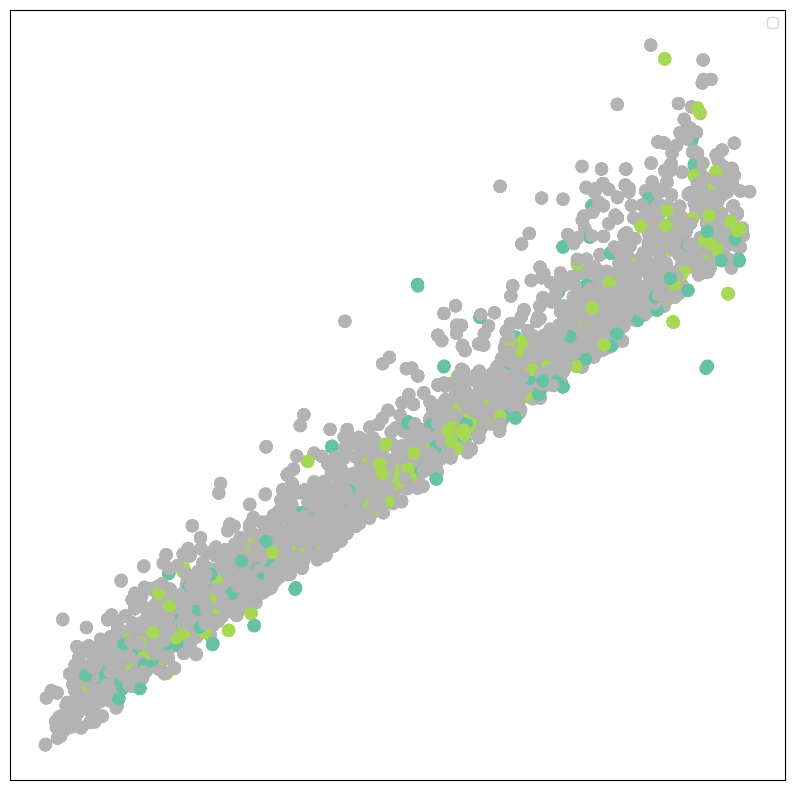

GraphSAGE(16, 3, num_layers=30)

In [71]:
model.eval()
dataset_val = dataset_val.sort(sort_by_row=False)
out = model(dataset_val.x.to(device), dataset_val.edge_index.to(device))
visualize(out.cpu(), color=dataset_val.y)
model.train()

In [72]:
from IPython import display

def pltsin(ax, h, color, hdisplay, colors=['b']):
    z = TSNE(n_components=2).fit_transform(h.detach().numpy())
    ax.cla()
    ax.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    hdisplay.update(fig)
    
fig,ax = plt.subplots(1,1)
hdisplay = display.display("", display_id=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

weight = compute_class_weight(class_weight='balanced',classes=np.unique(dataset_val.y.detach().numpy()),y=dataset_val.y.detach().numpy())
weight[2] = weight[2]/2
criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor(weight).type(torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
def train(loader):
    loss_end = 0
    for dataset in loader:
        dataset = transform(dataset)
        dataset = dataset.sort(sort_by_row=False)
        optimizer.zero_grad()
        out = model(dataset.x.to(device), dataset.edge_index.to(device))
        loss = criterion(out, dataset.y.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        loss_end += loss
    return loss_end, out
epochs = range(1, 20001)
losses = []
embeddings = []
randScore = []
class_report = []
loss_old = 0
counter = 0
for epoch in tqdm(epochs):
    loss, h = train(loader)
    losses.append(loss.cpu().detach().numpy())
    #embeddings.append(h)
    if loss > loss_old:
        counter += 1
    else:
        counter = 0
        torch.save(model.state_dict(), 
                   re.sub('hyperparameter_pickle_files','GCN_models',param_file))
    loss_old = loss
    if counter > 100:
        break
    if epoch%10==0:
        model.eval()
        dataset_val = dataset_val.sort(sort_by_row=False)
        out = model(dataset_val.x.to(device), dataset_val.edge_index.to(device))
        randScore.append(rand_score(dataset_val.y.detach().numpy(),np.argmax(out.cpu().detach().numpy(),axis=1)))
        class_report.append(classification_report(dataset_val.y.detach().numpy(),np.argmax(out.cpu().detach().numpy(),axis=1)))
        model.train()
plt.close(fig)
#np.save(re.sub('.pickle','_randScore.npy',re.sub('hyperparameter_pickle_files','GCN_metrics',param_file)),np.array(randScore))
#np.save(re.sub('.pickle','_classRepo.npy',re.sub('hyperparameter_pickle_files','GCN_metrics',param_file)),np.array(class_report))

''

  0%|          | 9/20000 [00:01<1:03:20,  5.26it/s]/lustre06/project/6030665/rozakmat/torch_geom/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre06/project/6030665/rozakmat/torch_geom/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/lustre06/project/6030665/rozakmat/torch_geom/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [73]:
print(class_report[-1])



              precision    recall  f1-score   support

         0.0       0.29      0.17      0.21       592
         1.0       0.27      0.64      0.38       718
         2.0       0.97      0.91      0.94     12256

    accuracy                           0.87     13566
   macro avg       0.51      0.57      0.51     13566
weighted avg       0.90      0.87      0.88     13566



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


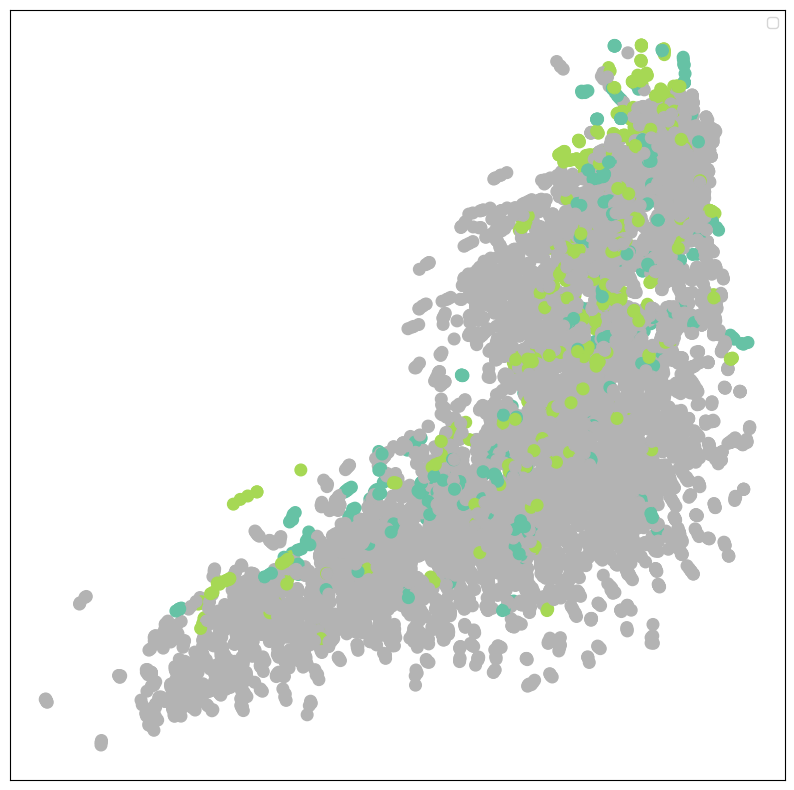

In [74]:
model.eval()
out = model(dataset_val.x.float().to(device), dataset_val.edge_index.to(device))
visualize(out.cpu(), color=dataset_val.y)

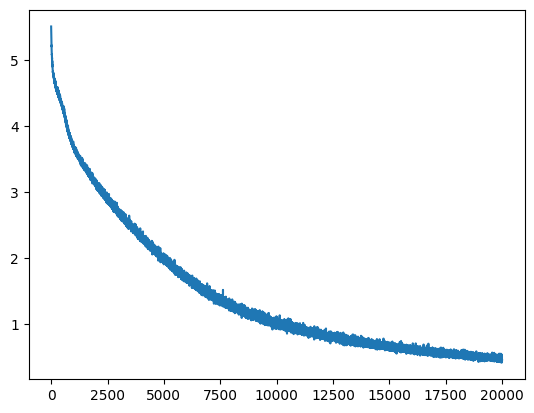

In [75]:
plt.plot(losses)

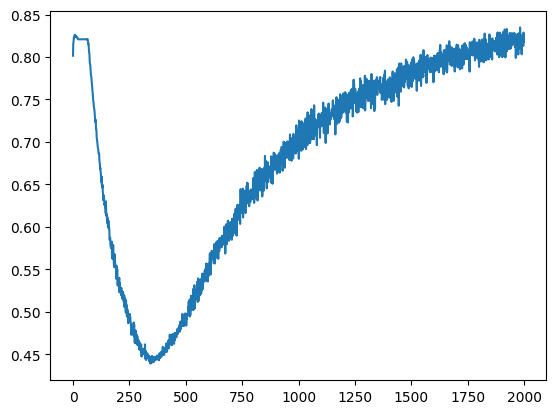

In [76]:
plt.plot(randScore)

In [ ]:
re.sub('.pickle','_randScore.npy',re.sub('hyperparameter_pickle_files','GCN_metrics',param_file))

In [ ]:
model.state_dict()

In [ ]:
np.argmax(out.cpu().detach().numpy(),axis=1)

In [ ]:
print(classification_report(dataset_val.y.detach().numpy(),np.argmax(out.cpu().detach().numpy(),axis=1)))

In [ ]:
np.unique(np.argmax(out.detach().numpy(),axis=1),return_counts=True)

In [ ]:
Recurrant autoencoder